# 4장.GAN-생성적 적대 신경망
<p align="center">
    <img src="https://dukakis.org/wp-content/uploads/sites/15/1-5-1-500x356.jpg")
<!-- ![](https://dukakis.org/wp-content/uploads/sites/15/1-5-1-500x356.jpg) -->
</p>
GAN의 창시자 Ian Goodfellow </p>
출처 : https://dukakis.org/about/aiws-standards-and-practice-committee/ian-goodfellow-2/

- GAN은 2016는 NIPS 듀토리얼에서 이안 굿펠로우에 의해서 처음 발표되었음
- 이후 수 많은 생성 알고리즘이 파생됨
- GAN을 "간" 또는 "갠" 이라고 읽는데, 나는 "갠" 이라 하겠다

## 4.1 애니멀GAN
### 4.1.1 Task 소개
$$
\min_{G}\max_{D}V(D,G)=\mathbb{E}_{x\sim{P_{data}(x)}}[\log{D(x)}]+\mathbb{E}_{z\sim{P_{z}(z)}}[\log{(1-D(G(z)))}]
$$
- Discriminator는 animalGAN 사진을 분별하고 Generator는 animalGAN 사진을 인위적으로 만들고싶어한다.
- 원본 animalGAN 사진 64장이 있다고 가정하자
    - D는 원본 64(class 1)장과 G가 랜덤하게 만들어낸 64장(class 0)을 보면서 진짜 사진을 학습한다.
    - 동시에 G는 새로운 사진 64장을 만들어내면서 D를 속이려한다.

### 4.1.2 camel(animalGAN) data 받고 확인하기
- animalGAN data를 다운로드받자 [[링크]](http://bit.ly/30HyNqg)
    1. camel.npy를 다운로드한다
    2. 이 ipynb이 있는 dir인 .에 ./data/camel folder를 만들고 거기에 다운로드받은 npy file을 넣으세요

In [1]:
import numpy as np

camel = np.load('./data/camel/full_numpy_bitmap_camel.npy')
camel.shape

(121399, 784)

In [2]:
784 == 28*28 # 아하! 28by 28 image를 flatten해서 저장했고 이런 이미지가 121399장 있구나~

True

In [2]:
import matplotlib.pyplot as plt

images = camel[0:10]
images = np.reshape(images, (-1,28,28))
print(images.shape)

(10, 28, 28)


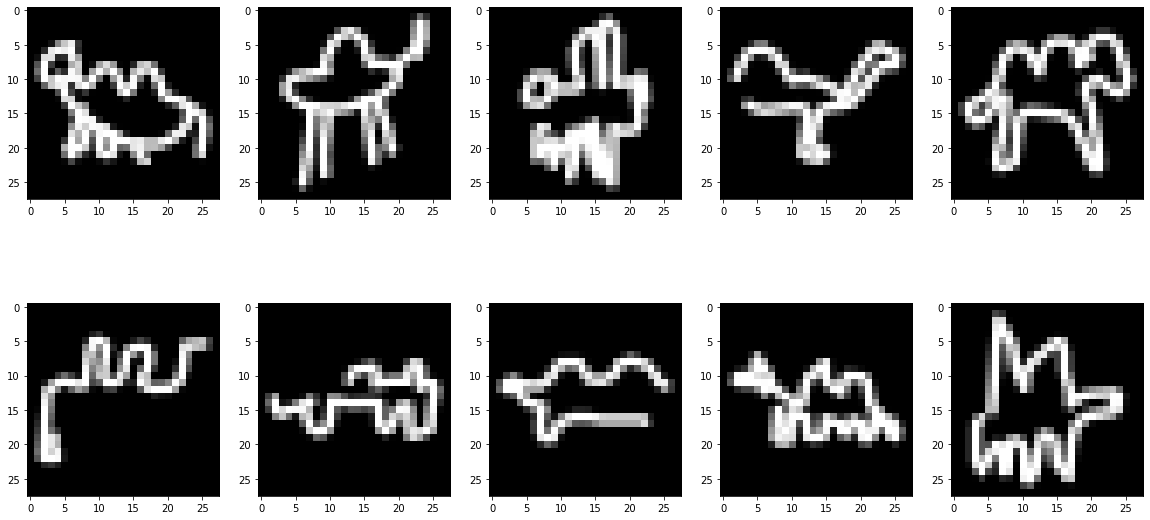

In [3]:
plt.figure(figsize=(20,10))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i], cmap='gray', interpolation='none')

## 4.2 첫 번째 GAN

### 4.2.1 판별자

In [5]:
import torch
import torch.nn as nn
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "1" # device가 없다는 오류가 뜨면 0으로 바꾸세요
device = torch.device('cuda')

class Discriminator(nn.Module):
    def __init__(self, size=28):
        super().__init__()
        self.size = size
        self.layers = nn.Sequential(nn.Conv2d(1,64,5,2,2),
                                    nn.ReLU(),
                                    nn.Dropout2d(p=0.4),
                                    nn.Conv2d(64,64,5,2,2),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.4),
                                    nn.Conv2d(64,128,5,2,2),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.4),
                                    nn.Conv2d(128,128,5,1,2),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.4)
                                    )
        self.dense = nn.Linear(2048, 2)
    
    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.shape[0],-1)
        x = self.dense(x)
        # 뒤에서 softmax해줄거라 sigmoid는 빼겠다
        return x


if __name__ == '__main__':
    x = torch.randn(10,1,28,28)
    D = Discriminator()
    y_pred = D(x)
    print(y_pred.shape)
    print(torch.nn.functional.softmax(y_pred,-1))

torch.Size([10, 2])
tensor([[0.5002, 0.4998],
        [0.4948, 0.5052],
        [0.5116, 0.4884],
        [0.5050, 0.4950],
        [0.5108, 0.4892],
        [0.4992, 0.5008],
        [0.5073, 0.4927],
        [0.4986, 0.5014],
        [0.4927, 0.5073],
        [0.5081, 0.4919]], grad_fn=<SoftmaxBackward0>)


In [6]:
from torchsummary import summary

D = Discriminator()
summary(D.cuda(0), (1,28,28))
del D

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
              ReLU-2           [-1, 64, 14, 14]               0
         Dropout2d-3           [-1, 64, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]         102,464
              ReLU-5             [-1, 64, 7, 7]               0
           Dropout-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]         204,928
              ReLU-8            [-1, 128, 4, 4]               0
           Dropout-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]         409,728
             ReLU-11            [-1, 128, 4, 4]               0
          Dropout-12            [-1, 128, 4, 4]               0
           Linear-13                    [-1, 2]           4,098
Total params: 722,882
Trainable params:

### 4.2.2 생성자

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_1 = nn.Sequential(nn.Linear(100, 3136),
                                      nn.BatchNorm1d(3136),
                                      nn.ReLU())
        self.layers_2 = nn.Sequential(nn.Upsample(14),
                                      nn.Conv2d(64,128,5,1,2),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(),
                                      nn.Upsample(28),
                                      nn.Conv2d(128,64,5,1,2),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),
                                      nn.Conv2d(64,64,5,1,2),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),
                                      nn.Conv2d(64,1,5,1,2)
                                      ) # ReLu가 오게되면 뒤의 sigmoid값의 최소가 무조건 0.5가 되버린다
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.layers_1(x)
        x = torch.reshape(x,(x.shape[0], 64, 7, 7))
        x = self.layers_2(x)
        x = self.sigmoid(x) # range : (0,1), 이미지 value가 0에서 1사이다
        return x


if __name__ == '__main__':
    x = torch.randn((32,100))
    G = Generator()
    generated = G(x)
    print(generated.shape)
    print(f'최소값 : {torch.min(generated).item()}, 최대값 : {torch.max(generated).item()}')

torch.Size([32, 1, 28, 28])
최소값 : 0.203001007437706, 최대값 : 0.832653284072876


In [8]:
G = Generator()
summary(G.cuda(0), (100,))
del G

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]         316,736
       BatchNorm1d-2                 [-1, 3136]           6,272
              ReLU-3                 [-1, 3136]               0
          Upsample-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 14, 14]         204,928
       BatchNorm2d-6          [-1, 128, 14, 14]             256
              ReLU-7          [-1, 128, 14, 14]               0
          Upsample-8          [-1, 128, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]         204,864
      BatchNorm2d-10           [-1, 64, 28, 28]             128
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]         102,464
      BatchNorm2d-13           [-1, 64, 28, 28]             128
             ReLU-14           [-1, 64,

### 4.2.3 Dataset

In [9]:
from torch.utils.data import Dataset, DataLoader

class Camel(Dataset):
    def __init__(self, split):
        super().__init__()
        camel = np.load('./data/camel/full_numpy_bitmap_camel.npy')
        if split == 'train':
            self.images = camel[0:8000]
        elif split == 'test':
            self.images = camel[8000:10000]

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx][None,...]/255.0 # (1,784)
        image = np.reshape(image, (1,28,28)) # (1,28,28)
        return image

if __name__ == '__main__':
    dataset = Camel('test')
    dataloader = DataLoader(dataset, 32)
    image = next(iter(dataloader))
    print(image.shape, type(image))

torch.Size([32, 1, 28, 28]) <class 'torch.Tensor'>


### 4.2.4 GAN 훈련
1. 먼저 판별자 D를 훈련하는 모델을 만든다(학습한다) + 동시에 G가 만든 샘플에는 속지 않는다. 이때, G의 parameter가 업데이트되지 않아야한다.
2. G는 랜덤한 인풋을 받아 가짜 이미지를 만들어 D를 속여야한다. 이때, D의 parameter가 업데이트되지 않아야한다.

- 여기서 G(또는 D)의 parameter가 업데이트되지 않아야한다는 것은 모두가 직관적으로 동의할 것이다. D를 업데이트하는데 G를 같이 업데이트하면 이것은 합성함수 D(G())의 최적이지 D의 최적은 아니기 때문이다. 그런데 어떻게 코드로 구현할건가?
- pytorch에는 ```SOME_TENSOR.detach()```나 ```SOME_TENSOR.clone()```로 비슷한 기능을 만드는 테크닉(이라기보다는 잡기술)이 있다. 하지만 이것을 전혀 사용 않고도 된다는 게 내 생각이다.
- torch의 optimizer는 최적화할 모델의 parameter를 받는다. 예를들면 ```model.parameters()```이런식으로. 이것은 loss가 step할 때, optimizer에서 지정된 parameter에 대해서만 step하겠다는 의미이다. 만약 D.parameters()를 지정해주었다면 내가 결과값을 출력한 함수가 G(D())여도 상관없다. 옵티마이저는 D에대해서만 step할 것이기 때문에..

In [10]:
# 학습 변수

epochs = 500
bs = 128
lr_g = 1e-3
lr_d = 1e-4

In [11]:
# Discriminator loss 만들기

class DiscriminatorLoss(nn.Module):
    def __init__(self, bs=32, gpu=True):
        super().__init__()
        self.celoss = torch.nn.BCEWithLogitsLoss()
        self.true = torch.cat([torch.zeros(bs,1),torch.ones(bs,1)],dim=-1)
        self.fake = torch.cat([torch.ones(bs,1),torch.zeros(bs,1)],dim=-1)
        if gpu:
            self.true = self.true.cuda()
            self.fake = self.fake.cuda()

    def forward(self, pred_real, pred_fake):
        loss = self.celoss(pred_real, self.true) +\
               self.celoss(pred_fake, self.fake)
        return loss


if __name__ == '__main__':
    critierion = DiscriminatorLoss(bs=bs)
    pred_real = torch.cat([torch.zeros(bs,1),torch.ones(bs,1)],dim=-1).cuda()
    pred_fake = torch.cat([torch.ones(bs,1),torch.zeros(bs,1)],dim=-1).cuda()
    loss = critierion(pred_real, pred_fake)
    print(loss.item())
    del critierion, pred_real, pred_fake, loss

1.006408929824829


In [12]:
# 모델과 critierion 선언

generator = Generator().cuda()
discriminator = Discriminator().cuda()

criterion_d = DiscriminatorLoss(bs=bs)
optimizer_d = torch.optim.RMSprop(params=discriminator.parameters(),lr=lr_d) # !중요 : D의 성능이 G에 비해 너무 빨리 올라서 D의 성능을 lr 조정을 통해 더디게 만들었다.

criterion_g = torch.nn.CrossEntropyLoss()
optimizer_g = torch.optim.RMSprop(params=generator.parameters(),lr=lr_g)

In [13]:
# 학습
from tqdm import tqdm
import torch.nn.functional as F

train_dataset = Camel('train')
train_dataloader = DataLoader(train_dataset, bs, shuffle=True, drop_last=True)
test_dataset = Camel('test')
test_dataloader = DataLoader(test_dataset, bs, shuffle=True, drop_last=True)

train_discriminator_loss = []
train_generator_loss = []

z_seed = torch.randn((5,100)).cuda()
results = []

g_target = torch.cat([torch.zeros(bs,1),torch.ones(bs,1)],dim=-1).cuda()

for epoch in tqdm(range(epochs)):
    for i,(image) in enumerate(train_dataloader):
        image = image.type(torch.FloatTensor).cuda()
        z = torch.randn((bs, 100)).cuda()
        
        # discriminator 학습
        ## optimizer_d와 optimizer_g는 각각 D와 G에 대해서만 최적화를 진행하므로 따로 freeze하지 않아도 같은 효과를 낸다
        pred_real = discriminator(image) # (bs, 2) -> [0,1]로 예측하게
        pred_fake = discriminator(generator(z)) # (bs, 2) -> [1,0]으로 예측하게, G freeze
        loss_d = criterion_d(pred_real, pred_fake)
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
        train_discriminator_loss.append(loss_d.item())

        # generator 학습
        generated = discriminator(generator(z)) # (bs, 2) -> [0,1]로 예측하게, D freeze
        generated = F.softmax(generated, dim=-1)
        loss_g = criterion_g(generated, g_target)
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        train_generator_loss.append(loss_g.item())

    # 중간 점검용
    if (epoch+1)%100==0:
        results.append(generator(z_seed).detach())

100%|██████████| 500/500 [50:49<00:00,  6.10s/it]


### 4.2.5 Test set으로 생성결과 보기

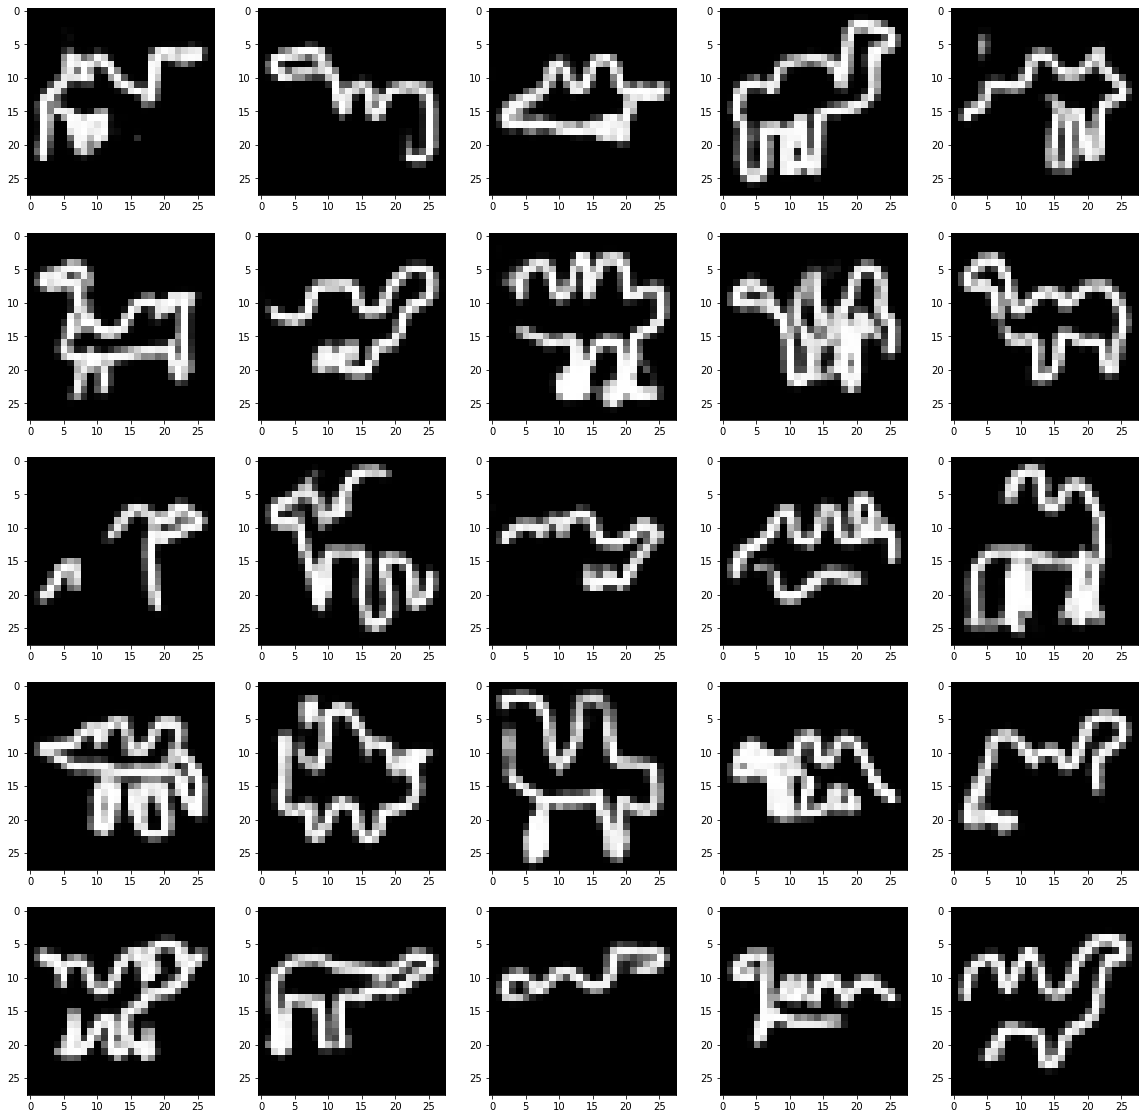

In [14]:
z = torch.randn((25,100)).cuda()

generated = generator(z).detach() # (25, 1, 28, 28)

plt.figure(figsize=(20,20))
for i in range(1,25+1):
    img = generated[i-1].cpu().numpy()
    plt.subplot(5,5,i)
    plt.imshow(np.einsum('c...->...c',img), cmap='gray', interpolation=None)

## 4.3 GAN의 도전 과제

### 4.3.1 진동하는 Loss
- 대략 1로 둘이 수렴하고 있는 것은 좋은 현상으로 보이나 $D$에 비해서 $G$가 분발하지 못하는 모습이다

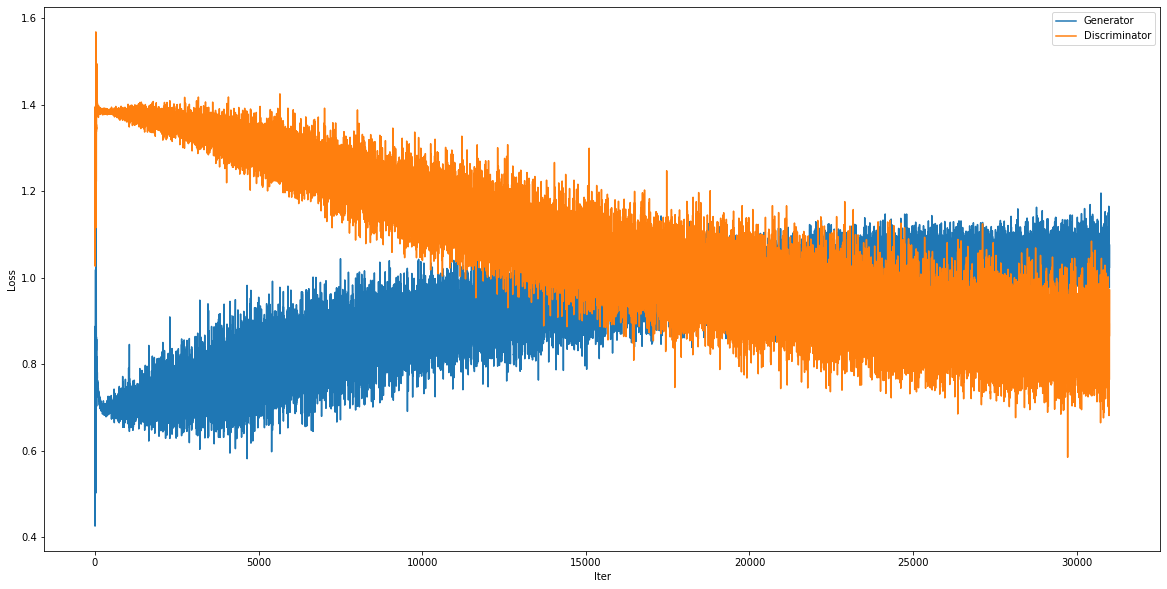

In [15]:
plt.figure(figsize=(20,10))

plt.plot(train_generator_loss, label='Generator')
plt.plot(train_discriminator_loss, label='Discriminator')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4.3.2 Mode Collapse

<p align="center">
    <img src="https://user-images.githubusercontent.com/69405481/101435883-09627800-3905-11eb-9709-da842ec5e2d6.jpg")
<!-- ![](https://dukakis.org/wp-content/uploads/sites/15/1-5-1-500x356.jpg) -->
</p>
G가 D를 속일 수 있는 단 하나의 샘플에만 수렴해버리는 경우 </p>
출처 : https://github.com/lucidrains/stylegan2-pytorch/issues/183

### 4.3.2 손실함수 최적화 != 실제 생성 품질

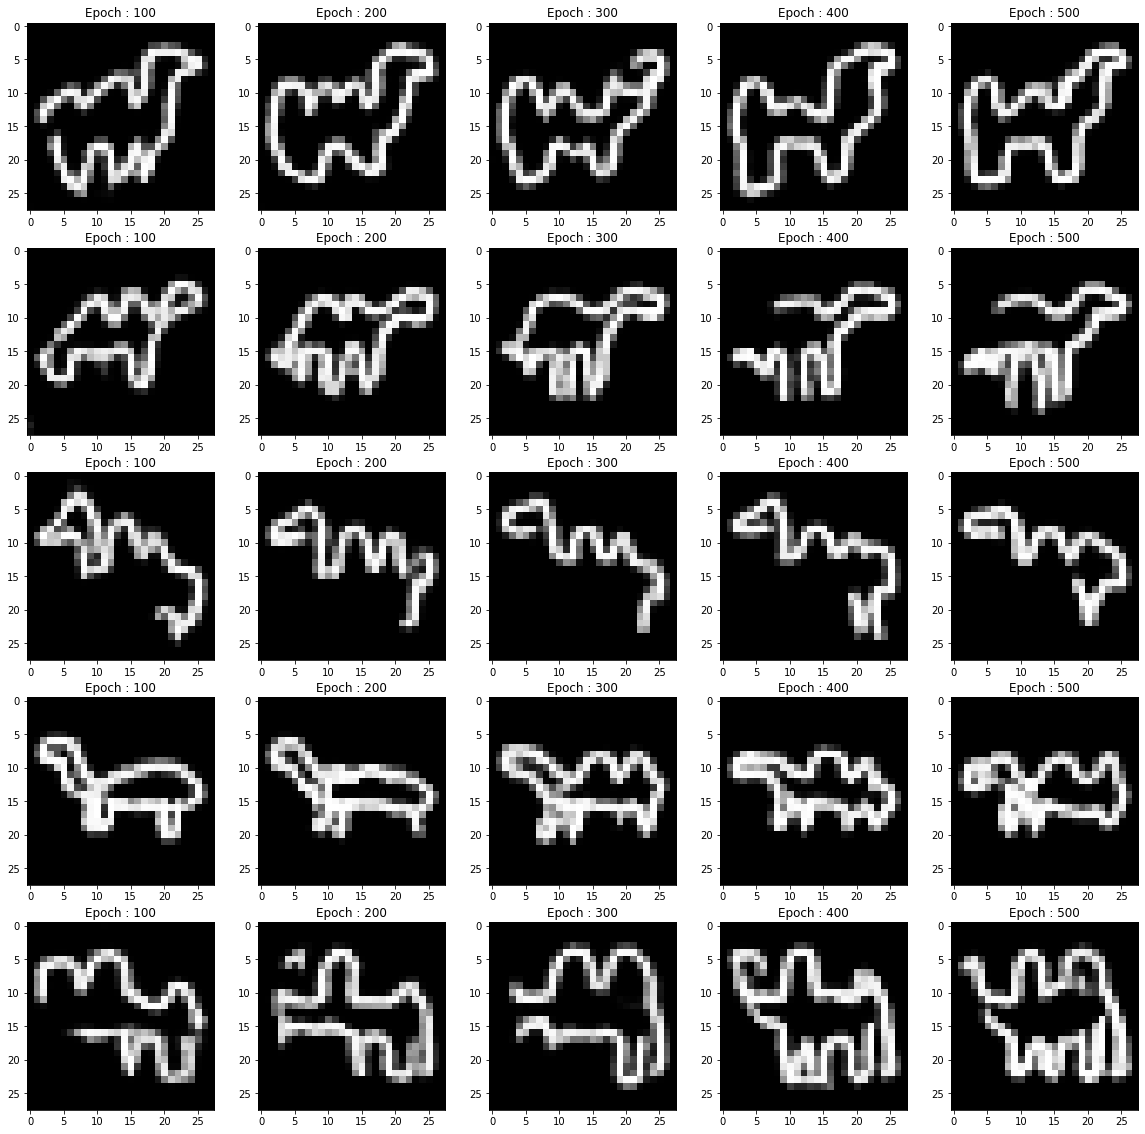

In [16]:
plt.figure(figsize=(20,20))

for col in range(1,5+1):
    images = results[col-1]
    images = images.detach().cpu().numpy()
    for row in range(1,5+1):
        img = np.einsum('c...->...c',images[row-1]) 
        plt.subplot(5,5,(row-1)*5+col)
        plt.imshow(img,cmap='gray',interpolation=None)
        plt.title(f'Epoch : {[100, 200, 300, 400, 500][col-1]}')

### 4.3.3 하이퍼파라미터
- GAN은 하이퍼파라미터 세팅에 너무 민감하다
- 네트워크의 시시콜콜한 구조부터 배치, LR, Latent space의 크기, 커널 크기... 등등 뭐 하나라도 맘에 안들면 제대로 안한다

## 4.4 WGAN - 와서스테인 GAN
$$
\min_G \max_D V(D,G)=\mathbb E_{x\sim{P_{data}(x)}}[D(x)]-\mathbb E_{z\sim{p_z(z)}}[D(G(z))]
$$
- 위에서는 CELoss를 사용해서 판별했다
    - 엄밀하게 말해서는 원래 GAN논문의 세팅과 다르다
    - 여기서는 원 논문과 그대로 Loss term을 구성해보겠다

### 4.4.1 판별자

In [40]:
class Discriminator(nn.Module):
    def __init__(self, size=28):
        super().__init__()
        self.size = size
        self.layers = nn.Sequential(nn.Conv2d(1,64,5,2,2),
                                    nn.ReLU(),
                                    nn.Dropout2d(p=0.4),
                                    nn.Conv2d(64,64,5,2,2),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.4),
                                    nn.Conv2d(64,128,5,2,2),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.4),
                                    nn.Conv2d(128,128,5,1,2),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.4)
                                    )
        self.dense = nn.Linear(2048, 1)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.shape[0],-1)
        x = self.dense(x)
        x = self.tanh(x) # [-1, 1]
        return x # (bs, 1) shape


if __name__ == '__main__':
    x = torch.randn(10,1,28,28)
    D = Discriminator()
    y_pred = D(x)
    print(y_pred.shape)
    print(y_pred)

torch.Size([10, 1])
tensor([[ 0.0113],
        [ 0.0323],
        [-0.0029],
        [ 0.0266],
        [ 0.0424],
        [ 0.0492],
        [ 0.0320],
        [ 0.0416],
        [ 0.0316],
        [ 0.0375]], grad_fn=<TanhBackward0>)


### 4.4.2 학습

In [41]:
epochs = 10
bs = 128
lr_g = 1e-3
lr_d = 1e-4

In [42]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

optimizer_d = torch.optim.RMSprop(params=discriminator.parameters(),lr=lr_d) # !중요 : D의 성능이 G에 비해 너무 빨리 올라서 D의 성능을 lr 조정을 통해 더디게 만들었다.
optimizer_g = torch.optim.RMSprop(params=generator.parameters(),lr=lr_g)

In [43]:
# 학습
from tqdm import tqdm
import torch.nn.functional as F

train_discriminator_fake_loss = []
train_discriminator_real_loss = []
train_generator_loss = []

z_seed = torch.randn((5,100)).cuda()
results = []

for epoch in tqdm(range(epochs)):
    for i,(image) in enumerate(train_dataloader):
        image = image.type(torch.FloatTensor).cuda()
        
        # discriminator 학습
        ## optimizer_d와 optimizer_g는 각각 D와 G에 대해서만 최적화를 진행하므로 따로 freeze하지 않아도 같은 효과를 낸다
        pred_real = discriminator(image) # (bs, 1) -> 1로 예측하게
        pred_fake = discriminator(generator(z)) # (bs, 1) -> -1로 예측하게
        loss_d_real = torch.mean(pred_real)
        loss_d_fake = torch.mean(pred_fake)
        loss_d = -loss_d_real + loss_d_fake # min(-(+1)+(-1))
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
        train_discriminator_real_loss.append(loss_d_real.item())
        train_discriminator_fake_loss.append(loss_d_fake.item())

        for parameter in discriminator.parameters():
            parameter.data.clamp_(-0.01, 0.01)

        # generator 학습, 5eph 마다 G가 학습되게 수정해보았다
        if (i+1)%5 == 0:
            z = torch.randn((bs, 100)).cuda()
            generated = discriminator(generator(z)) # (bs, 1) -> 1로 예측하게
            loss_g = -torch.mean(generated) # min(-(+1))
            optimizer_g.zero_grad()
            loss_g.backward()
            optimizer_g.step()
            train_generator_loss.append(loss_g.item())

    # 중간 점검용
    if (epoch+1)%100==0:
        results.append(generator(z_seed).detach())

100%|██████████| 10/10 [00:42<00:00,  4.20s/it]


### 4.4.3 학습결과

None


tensor([[ 0.6470, -0.3690,  0.7475],
        [ 0.9505,  0.0362,  0.8220],
        [ 1.6696,  0.1968, -0.1232]], requires_grad=True)